In [1]:
import sys
sys.path.insert(0, '/mnt/home/mlee1/vdm_BIND')

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from bind.workflow_utils import ConfigLoader, ModelManager, sample
from vdm.astro_dataset import get_astro_data
from analysis.paper_utils import setup_plotting_style

setup_plotting_style()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/mnt/sw/nix/store/6qvrglgqdpwhbw9zv2nh07fpd7a4wq31-py-torchvision-0.15.2/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Using device: cuda


## 1. Define Models to Compare

Each model needs a config file path. The `ConfigLoader` finds the best checkpoint automatically.

In [2]:
# Model configurations: {display_name: config_path}
MODELS = {
    'VDM': '/mnt/home/mlee1/vdm_BIND/configs/clean_vdm_aggressive_stellar.ini',
    'Triple VDM': '/mnt/home/mlee1/vdm_BIND/configs/clean_vdm_triple.ini',
    'DDPM': '/mnt/home/mlee1/vdm_BIND/configs/ddpm.ini',
    'Interpolant': '/mnt/home/mlee1/vdm_BIND/configs/interpolant.ini',
    'DSM': '/mnt/home/mlee1/vdm_BIND/configs/dsm.ini',
    'OT Flow': '/mnt/home/mlee1/vdm_BIND/configs/ot_flow.ini',
}

CHANNEL_NAMES = ['Hydro DM', 'Gas', 'Stars']

## 2. Load Test Data

In [3]:
# Load one batch from test set
test_root = '/mnt/home/mlee1/ceph/train_data_rotated2_128_cpu/test/'
datamodule = get_astro_data('IllustrisTNG', test_root, batch_size=4, num_workers=4, stage='test')
datamodule.setup(stage='test')
test_batch = next(iter(datamodule.test_dataloader()))

# Extract components: condition, target, large-scale maps, params
conditions, targets, large_scale_maps, params = test_batch
print(f"Condition: {conditions.shape}, Target: {targets.shape}, Large-scale: {large_scale_maps.shape}")

✓ Loaded DM stats: mean=9.915499, std=0.467967
✓ Loaded Gas stats: mean=9.177344, std=0.410510
✓ Loading stellar Z-score stats from: /mnt/home/mlee1/vdm_BIND/data/stellar_normalization_stats.npz
  mean=6.995926, std=1.100350

📊 NORMALIZATION CONFIG (3-channel mode):
  DM input: mean=9.9777, std=0.4139
  DM target: mean=9.9155, std=0.4680
  Gas target: mean=9.1773, std=0.4105
  Stars target: mean=6.9959, std=1.1004
✓ Loaded DM stats: mean=9.915499, std=0.467967
✓ Loaded Gas stats: mean=9.177344, std=0.410510
✓ Loading stellar Z-score stats from: /mnt/home/mlee1/vdm_BIND/data/stellar_normalization_stats.npz
  mean=6.995926, std=1.100350

📊 NORMALIZATION CONFIG (3-channel mode):
  DM input: mean=9.9777, std=0.4139
  DM target: mean=9.9155, std=0.4680
  Gas target: mean=9.1773, std=0.4105
  Stars target: mean=6.9959, std=1.1004
📂 Scanning data directory (this may take a few minutes on first run)...
   Path: /mnt/home/mlee1/ceph/train_data_rotated2_128_cpu/test/
   Found 42720 files in 1.77

## 3. Load Models & Generate Samples

In [4]:
# Select one halo for comparison
IDX = 0
cond = conditions[IDX:IDX+1]  # (1, 1, H, W)
large_scale = large_scale_maps[IDX:IDX+1]  # (1, 3, H, W)
target = targets[IDX]  # (3, H, W)
param = params[IDX:IDX+1]  # (1, N)

# Full conditioning = DM + large-scale context
full_cond = torch.cat([cond, large_scale], dim=1)  # (1, 4, H, W)

# Store samples from each model
samples = {}

In [5]:
# Load each model and generate a sample
for name, config_path in MODELS.items():
    if not Path(config_path).exists():
        print(f"⚠️ Skipping {name}: config not found")
        continue
    
    try:
        print(f"\n{'='*50}\nLoading {name}...")
        config = ConfigLoader(config_path, verbose=False)
        
        if config.best_ckpt is None:
            print(f"⚠️ Skipping {name}: no checkpoint found")
            continue
        
        _, model = ModelManager.initialize(config, verbose=False, skip_data_loading=True)
        model = model.to(DEVICE).eval()
        
        # Generate sample
        with torch.no_grad():
            s = sample(model, full_cond, batch_size=1, conditional_params=param.numpy())
            samples[name] = s[0, 0].cpu().numpy()  # (3, H, W)
        
        print(f"✓ {name} loaded and sampled")
        del model
        torch.cuda.empty_cache()
        
    except Exception as e:
        print(f"❌ Failed to load {name}: {e}")


Loading VDM...


Seed set to 8


✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Final decoder channels: 64 (GroupNorm groups: 8)
✓ Parameter predictor added (predicts 35 params)

INITIALIZING CLEAN VDM MODEL

📊 MODEL CONFIGURATION:
  Image shape: (3, 128, 128)
  Noise schedule: learned_nn
  Gamma range: [-13.3, 13.0]
  Data noise (per-channel): (0.0005, 0.0005, 0.0005)
  Loss weights (diffusion, latent, recons): 1.0, 1.0, 1.0

🎯 CHANNEL WEIGHTS: (1, 1, 1)

✓ Parameter prediction enabled (weight=0.01)




Generating Samples: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]
Seed set to 42


✓ VDM loaded and sampled

Loading Triple VDM...
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 37
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Final decoder channels: 64 (GroupNorm groups: 8)
✓ Parameter predictor added (predicts 35 params)
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 37
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 7

Generating Samples: 100%|██████████| 1/1 [00:05<00:00,  5.96s/it]
Seed set to 8


✓ Triple VDM loaded and sampled

Loading DDPM...


Sampling from the prior | t = 0.0 | sigma = 2.4e-02| scale ~ 9.0e+00: 100%|██████████| 250/250 [00:05<00:00, 47.42it/s]
Generating Samples: 100%|██████████| 1/1 [00:05<00:00,  5.28s/it]
Seed set to 8


✓ DDPM loaded and sampled

Loading Interpolant...
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Final decoder channels: 64 (GroupNorm groups: 8)
✓ Parameter predictor added (predicts 35 params)

INITIALIZED LIGHT INTERPOLANT MODEL
  Learning rate: 0.0001
  Sampling steps: 50
  Stochastic: False (sigma=0.0)
  x0 mode: dm_copy
  Param conditioning: True



Generating Samples: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]
Seed set to 8


✓ Interpolant loaded and sampled

Loading DSM...
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Final decoder channels: 64 (GroupNorm groups: 8)
✓ Parameter predictor added (predicts 35 params)

INITIALIZED LIGHT DSM MODEL (Custom UNet)
  Beta range: [0.1, 20.0]
  Learning rate: 0.0001
  Sampling steps: 250
  SNR weighting: True
  Channel weights: (1.0, 1.0, 1.0)
  Param conditioning: True



Generating Samples: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]
Seed set to 8


✓ DSM loaded and sampled

Loading OT Flow...
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Final decoder channels: 64 (GroupNorm groups: 8)
✓ Parameter predictor added (predicts 35 params)

INITIALIZED OT FLOW MATCHING MODEL
  Learning rate: 0.0001
  Sampling steps: 50
  OT method: exact
  Stochastic: False (sigma=0.0)
  x0 mode: dm_copy
  Use OT training: True
  POT available: True



Generating Samples: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

✓ OT Flow loaded and sampled


## 4. Compare Results

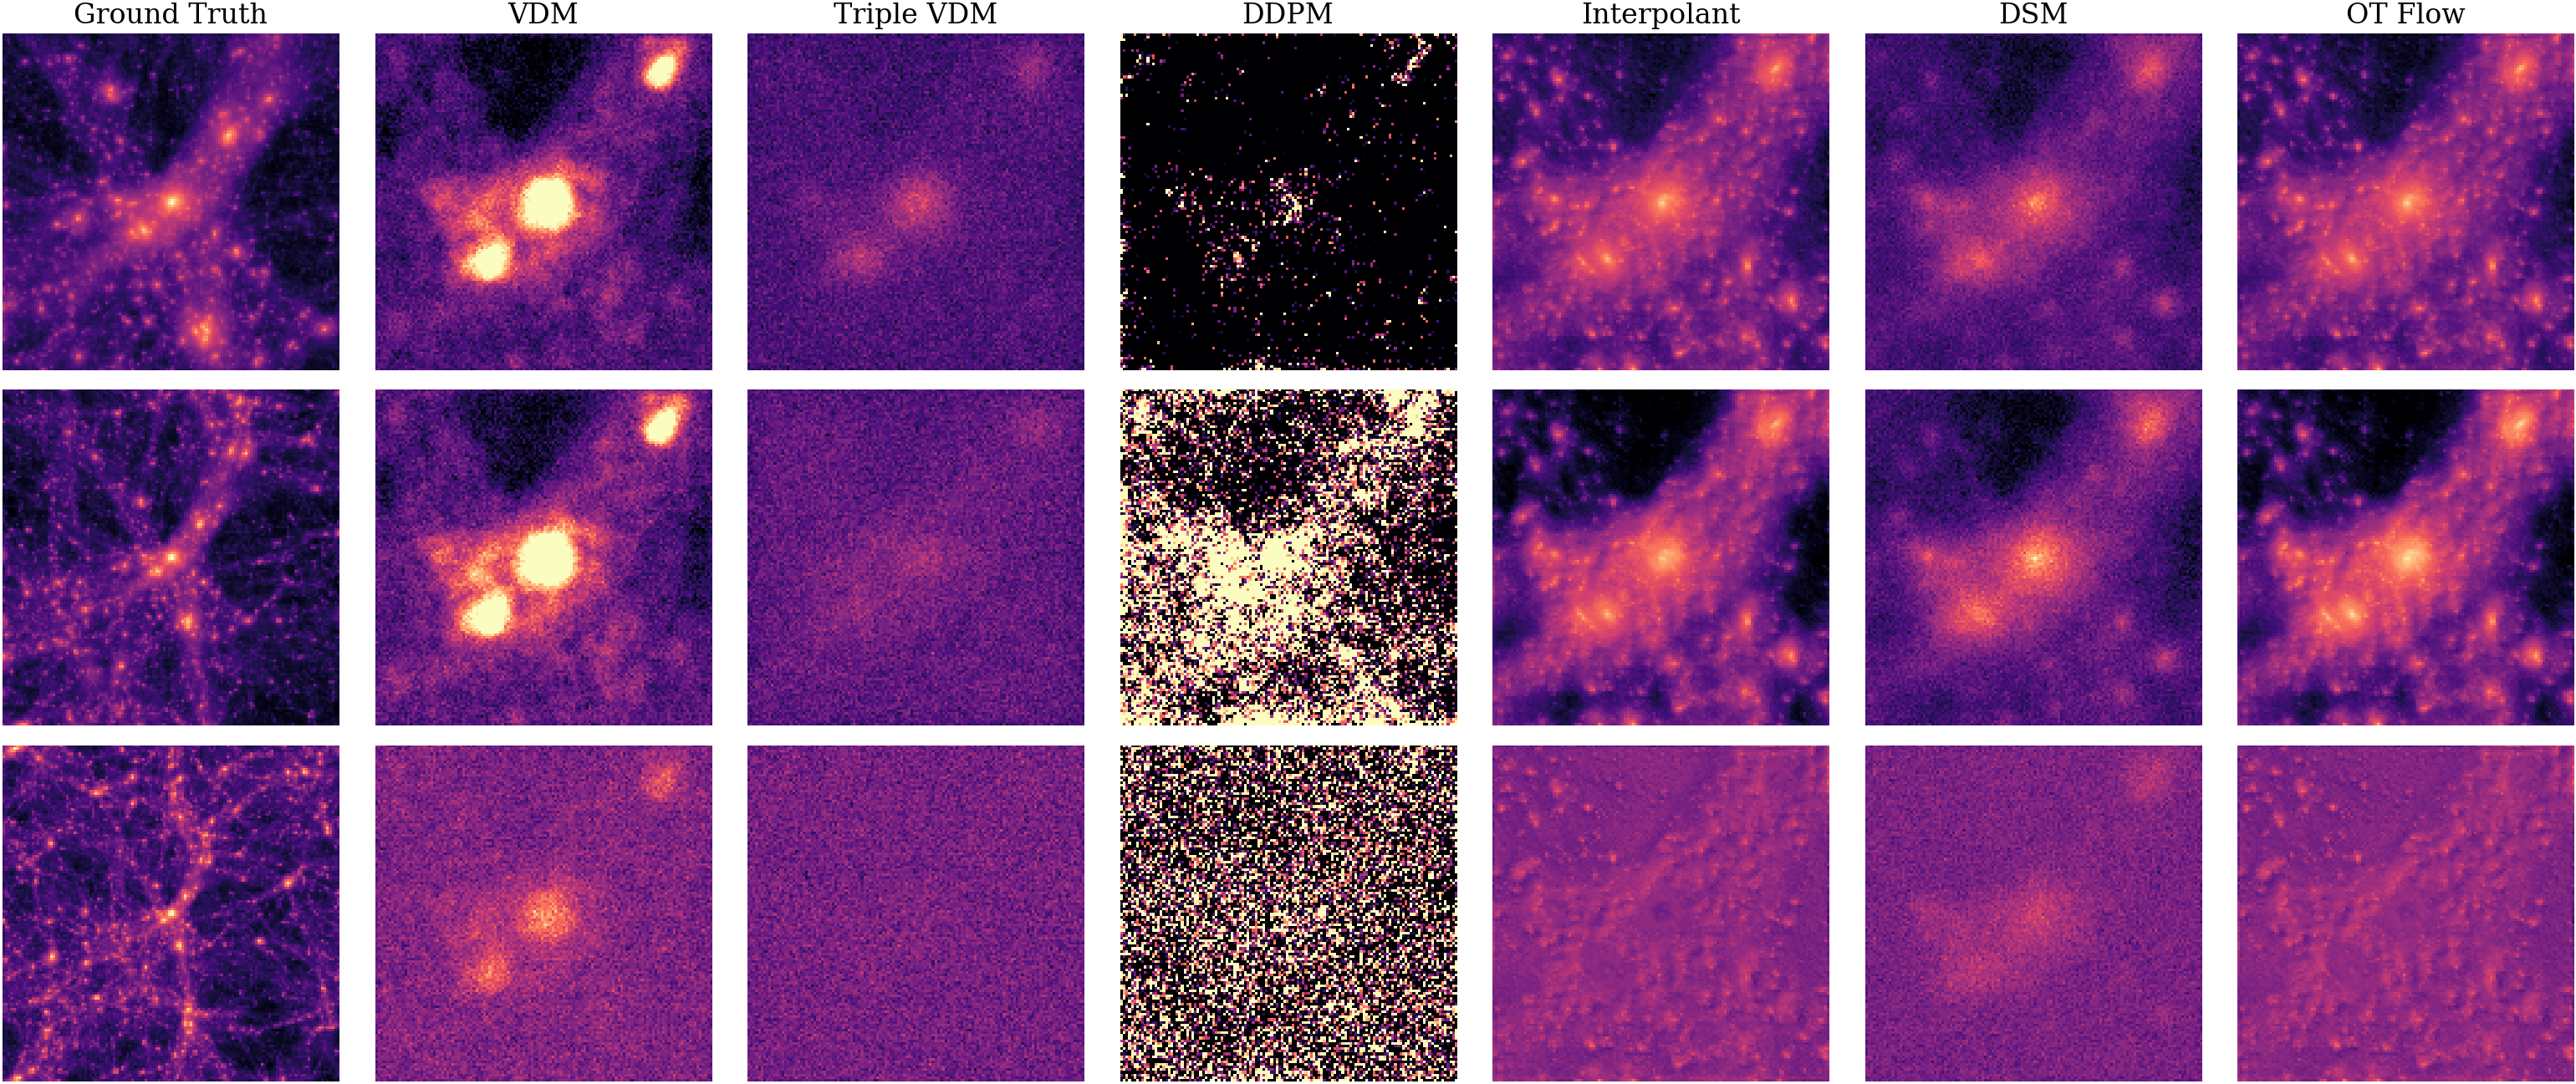

In [6]:
# Plot comparison: Ground Truth + each model
n_models = len(samples)
fig, axes = plt.subplots(3, n_models + 1, figsize=(3*(n_models+1), 9))

# Ground truth (first column)
for ch in range(3):
    im = axes[ch, 0].imshow(target[ch].numpy(), cmap='magma')
    axes[ch, 0].set_title('Ground Truth' if ch == 0 else '')
    axes[ch, 0].set_ylabel(CHANNEL_NAMES[ch])
    axes[ch, 0].axis('off')

# Model predictions
for col, (name, pred) in enumerate(samples.items(), 1):
    for ch in range(3):
        vmin, vmax = target[ch].numpy().min(), target[ch].numpy().max()
        axes[ch, col].imshow(pred[ch], cmap='magma', vmin=vmin, vmax=vmax)
        axes[ch, col].set_title(name if ch == 0 else '')
        axes[ch, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Residuals (predicted - ground truth)
fig, axes = plt.subplots(3, n_models, figsize=(3*n_models, 9))
if n_models == 1:
    axes = axes[:, np.newaxis]

for col, (name, pred) in enumerate(samples.items()):
    for ch in range(3):
        residual = pred[ch] - target[ch].numpy()
        vlim = max(abs(residual.min()), abs(residual.max()))
        axes[ch, col].imshow(residual, cmap='RdBu_r', vmin=-vlim, vmax=vlim)
        axes[ch, col].set_title(f'{name}' if ch == 0 else '')
        axes[ch, col].set_ylabel(CHANNEL_NAMES[ch] if col == 0 else '')
        axes[ch, col].axis('off')

plt.suptitle('Residuals (Prediction - Ground Truth)', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Quick metrics: MSE and correlation per channel
from scipy.stats import pearsonr

metrics = []
for name, pred in samples.items():
    for ch, ch_name in enumerate(CHANNEL_NAMES):
        gt = target[ch].numpy().flatten()
        pr = pred[ch].flatten()
        mse = np.mean((gt - pr)**2)
        corr, _ = pearsonr(gt, pr)
        metrics.append({'Model': name, 'Channel': ch_name, 'MSE': mse, 'Correlation': corr})

import pandas as pd
df = pd.DataFrame(metrics)
print(df.pivot(index='Model', columns='Channel', values='MSE').round(4))
print()
print(df.pivot(index='Model', columns='Channel', values='Correlation').round(4))